In [1]:
def determine(lst):
    return (all(x == 0.0 for x in lst))

def check_zeros(data):
    new_data = []
    for i in data:
        if not determine(i[1]):
            if new_data == None:
                new_data = i
            else:
                new_data.append(i)
#     data = [i for i in data if not determine(i[1])]
#     for item in data[:]:
#         if sum(item[1]) == 0:
#             data.pop(data.index(item))
    # for i, value in enumerate(data.copy()):
    #     if sum(value[1]) == 0:
    #         data.pop(i)
    return new_data


def merge_dataframe(df1, df2, column_names):
    final_df = df1
    return final_df.join(df2[column_names].set_index('pid'), on='pid', how='inner')


#get all the data from a specific order
def get_data_order(data, order_name):
    new_data = []

    if (order_name == 'Coleoptera'):
        index_one = 0
    elif (order_name == 'Diptera'):
        index_one = 1
    elif (order_name == 'Hymenoptera'):
        index_one = 2
    elif (order_name == 'Lepidoptera'):
        index_one = 3
    
    for i in range(len(data)):
        code_order = data[i][2][index_one]
        if(code_order == 1):
            data[i][2] = [1,0]
        else:
            data[i][2] = [0,1]
        new_data.append(data[i])
            
    return new_data

def read_pids_fasta(file_fasta):
    pids = []
    for record in SeqIO.parse(file_fasta, "fasta"):
        record_id = record.id
        pids.append(record_id.split("|")[0])        
    return pids

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        pickle.dump(obj, output, protocol=2)
        
def split_new(data,training_percent):
    training_percent = float(training_percent)
    for i in range(len(data)):
        if i < int(len(data)*training_percent):
            data[i].append(['train'])
        else:
            data[i].append(['test'])
    return data
    
def split(feature_file,training_percent):

    training_percent = float(training_percent)
    
    with open("../feature_data/" + feature_file, 'rb') as file:
        data = pickle.load(file)
        for i in range(len(data)):
            if i < int(len(data)*training_percent):
                data[i].append(['train'])
            else:
                data[i].append(['test'])
        return data
        #save_object(data, "train_and_test/tt-" + str(training_percent) + "-" + feature_file)

def build_DNN(train_x,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net = tflearn.input_data(shape=[None, len(train_x[0])])
    # Two fully connected layers with 8 hidden units/neurons - optimal for this task
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, 4,activation='softmax')
    # number of intents, columns in the matrix train_y
    #net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
    # regression to find best parameters, during training
    net = tflearn.regression(net)

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_sequence_logs')
    return modell

def build_DNN_Arch1(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
    net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch1_logs', tensorboard_verbose=3)
    return model

def build_DNN_Arch2(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
#     net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch2_logs', tensorboard_verbose=3)
    return model

def train_DNN(model, train_x,train_y,classes):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit(train_x, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes[0]+'_'+classes[1]+'.tflearn')

def train_DNN_arch12(model, train_aa, train_nu, train_y,classes,arch):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model_name = 'model/'+classes+'_'+arch+'.tflearn'
    model.fit({"InputData0":train_aa,"InputData1":train_nu}, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes+'_'+arch+'.tflearn')
    return model_name
    
def predict_old(frequency,model,classes):

    ERROR_THRESHOLD = 0.5
    
    # generate probabilities from the model
    results = model.predict(frequency)[0]

    # filter out predictions below a threshold, and provide intent index
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append(classes[r[0]])
    
    return return_list

def predict(model, test_aa, test_nu,classes):
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]

    new_results = results
    if results[0] > results[1]:
        #new_results[0] = results[0]
        #new_results[1] = results[1]
        class_result = 0
    else:
        #new_results[0] = results[1]
        #new_results[1] = results[0]
        class_result = 1

    #return_list = []
    #return_list.append((classes[class_result], str(new_results[0])))
    return classes[class_result], results[0]

def predict_with_threshold(model, test_aa, test_nu,classes):
    
    THRESHOLD = 0.5
        
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]
    
    if(results[0] >= THRESHOLD):
        class_index = 0 #The first class is the positive class
    else:
        class_index = 1 

    return classes[class_index], results[0]

def fix_format(string):
    return re.sub('[\[\]\']','',string)

def plot_roc(y_test,y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = array(y_test)
    y_score = array(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def metrics_DNN(predict_y,id_test,test_y,classes,scores):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    id_misclassified = []
    pred_misclassified = []
    y_misclassified = []
    
    #class[0] is the positive class, test_y == 1 is the positive class
    for i in range(len(predict_y)):
        if (predict_y[i] == classes[0] and test_y[i] == 1):
            true_positive += 1
            
        elif (predict_y[i] == classes[1] and test_y[i] == 0):
            true_negative += 1
            
        elif(predict_y[i] == classes[1] and test_y[i] == 1):
            false_negative += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[0])
            
        elif(predict_y[i] == classes[0] and test_y[i] == 0):
            false_positive += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[1])
    
    
    df_misclassified = pd.DataFrame({'id': id_misclassified,'predicted': pred_misclassified,'real_class': y_misclassified})
            
    precision_classe0 = float(true_positive)/(true_positive + false_positive)
    sensitivity = float(true_positive)/(true_positive + false_negative) #recall for class0
    F1_score_class0 = 2*(float(precision_classe0*sensitivity)/(precision_classe0 + sensitivity))
    
    precision_classe1 = float(true_negative)/(true_negative + false_negative)
    specificity = float(true_negative)/(false_positive + true_negative)#recall for class1
    F1_score_class1 = 2*(float(precision_classe1*specificity)/(precision_classe1 + specificity))
    
    accuracy = float(true_positive + true_negative)/len(predict_y)
    
    print("Class " + classes[0] +":")
    print("Precision: " + str(precision_classe0))
    print("Sensitivity: " + str(sensitivity))
    print("F1 score: " + str(F1_score_class0))
    
    print("")
    
    print("Class " + classes[1] +":")
    print("Precision: " + str(precision_classe1))
    print("Specificity: " + str(specificity))
    print("F1 score: " + str(F1_score_class1))
    
    print("")
    
    print("Accuracy:")
    print(accuracy)

    plot_roc(test_y,scores)
    
    return df_misclassified

In [2]:
import numpy as np
import tflearn
import tensorflow as tf
import random
import pickle
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import argparse
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from numpy import array
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
nuc_data_first = {}
nuc_data_second = {}
nuc_data_third = {}
nuc_data_fourth = {}
amino_data_first = {}
amino_data_second = {}
amino_data_third = {}
amino_data_fourth = {}


with open("ensemble_data/1nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_first = pickle.load(file)
    print(nuc_data_first[0])
with open("ensemble_data/2nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_second = pickle.load(file)
    print(nuc_data_second[0])
with open("ensemble_data/3nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_third = pickle.load(file)
    print(nuc_data_third[0])
with open("ensemble_data/4nucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    nuc_data_fourth = pickle.load(file)
    print(nuc_data_fourth[0])
with open("ensemble_data/1aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_first = pickle.load(file)
    print(amino_data_first[0])
with open("ensemble_data/2aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_second = pickle.load(file)
    print(amino_data_second[0])
with open("ensemble_data/3aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_third = pickle.load(file)
    print(amino_data_third[0])
with open("ensemble_data/4aminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl", 'rb') as file:
    amino_data_fourth = pickle.load(file)
    print(amino_data_fourth[0])

['GWOTF048-12', [0.0721649485, 0.0, 0.0618556701, 0.0515463918, 0.0, 0.0, 0.0103092784, 0.0, 0.0206185567, 0.0, 0.0, 0.0, 0.0206185567, 0.0103092784, 0.0206185567, 0.0, 0.0, 0.0103092784, 0.0, 0.0103092784, 0.0, 0.0206185567, 0.0721649485, 0.0721649485, 0.0206185567, 0.0103092784, 0.0, 0.0618556701, 0.0206185567, 0.0103092784, 0.0, 0.0206185567, 0.0, 0.0, 0.0, 0.0, 0.0824742268, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 1]]
['DPAST165-11', [0.0412371134, 0.0103092784, 0.0412371134, 0.0618556701, 0.0412371134, 0.0, 0.0, 0.0, 0.0103092784, 0.0103092784, 0.0103092784, 0.0, 0.0103092784, 0.0103092784, 0.0, 0.0309278351, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0206185567, 0.0618556701, 0.0, 0.0412371134, 0.0103092784, 0.0103092784, 0.0103092784, 0.0103092784, 0.0309278351, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [4]:
print(len(nuc_data_first))
print(len(nuc_data_second))
print(len(nuc_data_third))
print(len(nuc_data_fourth))
print(len(amino_data_first))
print(len(amino_data_second))
print(len(amino_data_third))
print(len(amino_data_fourth))

353340
353539
354195
347431
353023
339718
348800
253134


In [5]:
nuc_data_first_order = get_data_order(nuc_data_first, 'Coleoptera')
nuc_data_second_order = get_data_order(nuc_data_second, 'Coleoptera')
nuc_data_third_order = get_data_order(nuc_data_third, 'Coleoptera')
nuc_data_fourth_order = get_data_order(nuc_data_fourth, 'Coleoptera')
amino_data_first_order = get_data_order(amino_data_first, 'Coleoptera')
amino_data_second_order = get_data_order(amino_data_second, 'Coleoptera')
amino_data_third_order = get_data_order(amino_data_third, 'Coleoptera')
amino_data_fourth_order = get_data_order(amino_data_fourth, 'Coleoptera')

In [6]:
nuc_data_1 =   pd.DataFrame(data = nuc_data_first_order,    columns=['pid', 'ndata_x1', 'data_y'])
nuc_data_2 =   pd.DataFrame(data = nuc_data_second_order,   columns=['pid', 'ndata_x2', 'data_y'])
nuc_data_3 =   pd.DataFrame(data = nuc_data_third_order,    columns=['pid', 'ndata_x3', 'data_y'])
nuc_data_4 =   pd.DataFrame(data = nuc_data_fourth_order,   columns=['pid', 'ndata_x4', 'data_y'])
amino_data_1 = pd.DataFrame(data = amino_data_first_order,  columns=['pid', 'adata_x1', 'data_y'])
amino_data_2 = pd.DataFrame(data = amino_data_second_order, columns=['pid', 'adata_x2', 'data_y'])
amino_data_3 = pd.DataFrame(data = amino_data_third_order,  columns=['pid', 'adata_x3', 'data_y'])
amino_data_4 = pd.DataFrame(data = amino_data_fourth_order, columns=['pid', 'adata_x4', 'data_y'])

In [7]:
final_df_1 = merge_dataframe(nuc_data_1, amino_data_1, ['pid', 'adata_x1'])
final_df_2 = merge_dataframe(nuc_data_2, amino_data_2, ['pid', 'adata_x2'])
final_df_3 = merge_dataframe(nuc_data_3, amino_data_3, ['pid', 'adata_x3'])
final_df_4 = merge_dataframe(nuc_data_4, amino_data_4, ['pid', 'adata_x4'])

In [8]:
final_df = merge_dataframe(final_df_1, final_df_2, ['pid', 'adata_x2', 'ndata_x2'])
final_df = merge_dataframe(final_df, final_df_3, ['pid', 'adata_x3', 'ndata_x3'])
final_df = merge_dataframe(final_df, final_df_4, ['pid', 'adata_x4', 'ndata_x4'])

In [9]:
final_df.head()

pid                                           ndata_x1  data_y  \
1   JCDB322-15  [0.0309278351, 0.0206185567, 0.0412371134, 0.0...  [0, 1]   
2  SARBF995-14  [0.0824742268, 0.0, 0.0927835052, 0.0206185567...  [0, 1]   
3  GWOTG920-12  [0.0618556701, 0.0103092784, 0.0824742268, 0.0...  [0, 1]   
5  JSDIP244-10  [0.0618556701, 0.0, 0.0618556701, 0.0412371134...  [0, 1]   
6  SMTPF586-14  [0.0515463918, 0.0103092784, 0.0515463918, 0.0...  [0, 1]   

                                            adata_x1  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0...   

                                            adata_x2  \
1  [0.03125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0....   
2  [0.03125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0....   
3  [0.03125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0....   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   

                                            ndata_x2  \
1  [0.0618556701, 0.0206185567, 0.0618556701, 0.0...   
2  [0.0412371134, 0.0103092784, 0.0412371134, 0.0...   
3  [0.0309278351, 0.0206185567, 0.0206185567, 0.0...   
5  [0.0618556701, 0.0103092784, 0.0309278351, 0.0...   
6  [0.0309278351, 0.0103092784, 0.0309278351, 0.0...   

                                            adata_x3  \
1  [0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0...   
2  [0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0...   
3  [0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0...   
5  [0.0, 0.03125, 0.0, 0.0, 0.03125, 0.0, 0.0, 0....   
6  [0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0...   

                                            ndata_x3  \
1  [0.0412371134, 0.0, 0.0309278351, 0.0, 0.01030...   
2  [0.0412371134, 0.0, 0.0309278351, 0.0, 0.0, 0....   
3  [0.0309278351, 0.0103092784, 0.0412371134, 0.0...   
5  [0.0309278351, 0.0, 0.0721649485, 0.0103092784...   
6  [0.0309278351, 0.0103092784, 0.0206185567, 0.0...   

                                            adata_x4  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0312...   

                                            ndata_x4  
1  [0.0618556701, 0.0412371134, 0.0412371134, 0.0...  
2  [0.0721649485, 0.0412371134, 0.0412371134, 0.0...  
3  [0.1134020619, 0.0721649485, 0.0309278351, 0.0...  
5  [0.1134020619, 0.0515463918, 0.0618556701, 0.0...  
6  [0.0824742268, 0.0721649485, 0.0412371134, 0.0...

In [10]:
cols = list(final_df.columns)
nuc_all_df = None
amino_all_df = None
#concat string
for i in [1,5,7,9]:
    if nuc_all_df is None:
        nuc_all_df = final_df[cols[i]]
    else:
        nuc_all_df += final_df[cols[i]]
#     final_df = final_df.drop([cols[i]], axis=1)
for i in [3,4,6,8]:
    if amino_all_df is None:
        amino_all_df = final_df[cols[i]]
    else:
        amino_all_df += final_df[cols[i]]
for i in [1,3,4,5,6,7,8,9]:
    final_df = final_df.drop([cols[i]], axis=1)
final_df['nuc_all'] = nuc_all_df
final_df['amino_all'] = amino_all_df
# final_list = final_df.iloc[:,2:3].values.tolist()
# print(final_list[:1])
# concat_df = final_df['ndata_x1'].values.tolist().extend(final_df['ndata_x2'].values.tolist())

In [11]:
final_df.head()

pid  data_y                                            nuc_all  \
1   JCDB322-15  [0, 1]  [0.0309278351, 0.0206185567, 0.0412371134, 0.0...   
2  SARBF995-14  [0, 1]  [0.0824742268, 0.0, 0.0927835052, 0.0206185567...   
3  GWOTG920-12  [0, 1]  [0.0618556701, 0.0103092784, 0.0824742268, 0.0...   
5  JSDIP244-10  [0, 1]  [0.0618556701, 0.0, 0.0618556701, 0.0412371134...   
6  SMTPF586-14  [0, 1]  [0.0515463918, 0.0103092784, 0.0515463918, 0.0...   

                                           amino_all  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0...

In [12]:
print(len(final_df_1))
print(len(final_df_2))
print(len(final_df_3))
print(len(final_df_4))

350820
338079
348547
252477


In [13]:
nu_list = final_df[['pid', 'nuc_all','data_y']].values.tolist()
aa_list = final_df[['pid', 'amino_all','data_y']].values.tolist()
nu_list = split_new(nu_list,0.1)
aa_list = split_new(aa_list,0.1)

In [14]:
pid_label = 0
index_x = 1
index_y = 2
index_label = 3
train_aa_x = [] 
train_nu_x = []
data_y_train = [] 
for i in range(len(nu_list)):
    if ((nu_list[i][index_label][0]) == 'train'):
        train_nu_x.append(nu_list[i][index_x])
        data_y_train.append(nu_list[i][index_y])
for i in range(len(aa_list)):
    if ((aa_list[i][index_label][0]) == 'train'):
        train_aa_x.append(aa_list[i][index_x])

# Train

In [15]:
%%time
#Train

#build architecture
classes = ['coleoptera', 'not_coleoptera']
model = build_DNN_Arch1(len(train_aa_x[0]), len(train_nu_x[0]),data_y_train)
#train
model_name = train_DNN_arch12(model, train_aa_x, train_nu_x, data_y_train,classes[0],'1')

Training Step: 23754  | total loss: 0.02678 | time: 16.577s
| Adam | epoch: 005 | loss: 0.02678 - acc: 0.9931 -- iter: 23750/23754
Training Step: 23755  | total loss: 0.02418 | time: 16.581s
| Adam | epoch: 005 | loss: 0.02418 - acc: 0.9944 -- iter: 23754/23754
--
INFO:tensorflow:/Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/coleoptera_1.tflearn is not in all_model_checkpoint_paths. Manually adding it.
CPU times: user 2min 11s, sys: 19.4 s, total: 2min 30s
Wall time: 2min 3s


# Test

In [16]:
#Get data for test
data_y_test = []
id_test = []        
test_aa_x = [] 
test_nu_x = []
for i in range(len(nu_list)):
    if ((nu_list[i][index_label][0]) == 'test'):
        test_nu_x.append(nu_list[i][index_x])
        data_y_test.append(nu_list[i][index_y])
        id_test.append(nu_list[i][pid_label])
for i in range(len(aa_list)):
    if ((aa_list[i][index_label][0]) == 'test'):
        test_aa_x.append(aa_list[i][index_x])


In [17]:
nu_list[0]

['JCDB322-15',
 [0.0309278351,
  0.0206185567,
  0.0412371134,
  0.0515463918,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0103092784,
  0.0103092784,
  0.0,
  0.0,
  0.0309278351,
  0.0206185567,
  0.0103092784,
  0.0,
  0.0,
  0.0206185567,
  0.0206185567,
  0.0,
  0.0,
  0.0,
  0.0927835052,
  0.0515463918,
  0.0206185567,
  0.0206185567,
  0.0103092784,
  0.0515463918,
  0.0,
  0.0206185567,
  0.0309278351,
  0.0103092784,
  0.0,
  0.0103092784,
  0.0,
  0.0,
  0.0412371134,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0105263158,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0618556701,
  0.0206185567,
  0.0618556701,
  0.0412371134,
  0.0412371134,
  0.0206185567,
  0.0,
  0.0,
  0.0103092784,
  0.0103092784,
  0.0,
  0.0,
  0.0103092784,
  0.0103092784,
  0.0,
  0.0103092784,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0103092784,
  0.04123711

In [18]:
%%time
import pandas as pd
#TEST
model = build_DNN_Arch1(len(train_aa_x[0]), len(train_nu_x[0]),data_y_train)
model.load(model_name)
result = []
scores = []
for i in range(len(test_aa_x)):
    cls, score = predict(model, test_aa_x[i], test_nu_x[i],classes)
    result.append(cls)
    scores.append(float(score))
    
df = pd.DataFrame(result)
df.columns = ['order']

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/coleoptera_1.tflearn
CPU times: user 1min 53s, sys: 13.6 s, total: 2min 7s
Wall time: 1min 30s


In [19]:
tes_first_neuron = [item[0] for item in data_y_test]

# Metrics

Class coleoptera:
Precision: 0.9676723564029505
Sensitivity: 0.9562391453081417
F1 score: 0.9619217788366091

Class not_coleoptera:
Precision: 0.9905640571717137
Specificity: 0.9930941112223537
F1 score: 0.9918274707200746

Accuracy:
0.9865431209482025


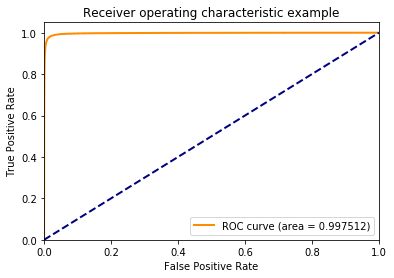

In [20]:
#Metrics
predict_data = df


# predict_data['order'] = [fix_format(x) for x in predict_data['order']]

#function that calculate all metrics

df_misclassified = metrics_DNN(predict_data['order'],id_test,tes_first_neuron,classes,scores)

In [21]:
df_misclassified.to_csv('output_data/'+'misclassified_data_'+classes[0]+'_'+classes[1]+'.tsv',index=False,sep='\t')

In [22]:
print(len(final_df))

237548
